# Tutorial: Reciever Operating Chararacteristic (ROC) curves and training classifiers in Python with Skikit Learn

These tools could allow us to ask whether activity in an area allows an ideal observer to detect stimulus presence/absence and how well it predicts subsequent behavioural choice.

We will walk through 3 things in this notebook:
* generating example data with numpy
* making a simple ROC curve that uses the mean over the whole population as the decision variable for each trial
* training a classifier that weights mean response of each cell to predict trial type, then making an ROC curve to evaluate the performance of this classifier on the test data

Reading the skikit learn documentation will be useful to understand the functions used: https://scikit-learn.org

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#generic imports
import sys
sys.path.extend(['..','../..'])
import pandas as pd
import numpy.random as random
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# make plots look pretty
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

In [4]:
# stats
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [5]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# ROC with decision variable as population mean

#### First, we will generate some example data in a similar format to the real data.

In [6]:
# Generate samples from two different gaussian distributions
#imagine there are 100 cells and 100000 recording frames from each cell for each trial type A and B
A = np.zeros((100,10000)) #trial type A
B = np.zeros((100,10000)) # trial type B

# Fill each row with samples drawn randomly from a normal distribution
for row in range(A.shape[0]):
    A[row,:] = np.random.normal(2,10,10000)
for row in range(B.shape[0]):
    B[row,:] = np.random.normal(2.14,8,10000)

In [7]:
# concatenate the matrices A and B along axis 1 such that there are 20000 frames per cell
all_trials = np.concatenate((A,B),axis=1)
all_trials.shape

(100, 20000)

In [8]:
# split the samples from each cell into 200 trials of length 100 frames
# the real data must be aligned with stimulus timings to determine the starting point of each trial
trials = np.split(all_trials,200,axis=1) 
print('number of trials = {}, shape of data for each trial = {}'.format(len(trials),trials[0].shape))

number of trials = 200, shape of data for each trial = (100, 100)


In [9]:
# each trial needs a label to indicate the trial type
# the first 10 trials were type 1 whilst the final 10 trials were type 2
labels = np.zeros((200))
labels[100:200] = 1
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# calculate mean response for each trial, for each cell
mean_dff_cell = np.mean(trials,axis=2)

# calculate mean response over the population for each trial
mean_dff_trial = np.mean(mean_dff_cell, axis = 1)

mean_dff_trial.shape # this gives us 1 datapoint per trial

(200,)

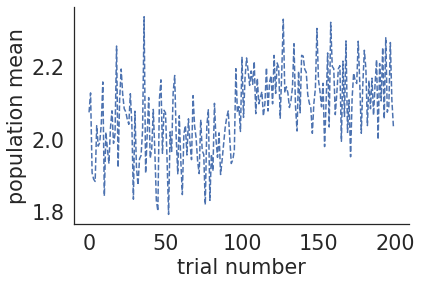

In [11]:
plt.plot(mean_dff_trial,'--')
plt.xlabel('trial number')
plt.ylabel('population mean')
plt.show()

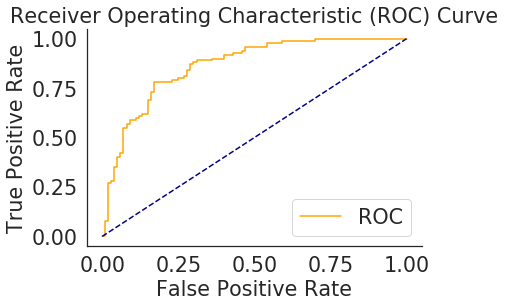

AUC: 0.86


In [12]:
# make ROC curve using skikit learn package
fpr, tpr, thresholds = roc_curve(labels, mean_dff_trial)
plot_roc_curve(fpr, tpr)
auc = roc_auc_score(labels, mean_dff_trial)
print('AUC: %.2f' % auc)

Using the average population response discards information about the differences between the responses of individual cells.

We could now make a linear classifier that weights the mean dff of each individual cell to make the classification, and repeat the ROC analysis using the output of this model.

Data needs to look like:
n cells x n trials 
Weight matrix needs to looks like:
n cells x 1 

## Example logistic regression classifier
many classifiers are available in the skikit-learn package https://scikit-learn.org/

In [13]:
from sklearn import linear_model

### 1. scale data such that it has zero-mean with unit variance

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(mean_dff_cell)
mean_dff_cell_scaled = scaler.transform(mean_dff_cell)

### 2. split data into train and test sets

In [15]:
trainX, testX, trainy, testy = train_test_split(mean_dff_cell_scaled, labels, test_size=0.25, random_state=1)

### 3. fit model to training data

In [16]:
clf = linear_model.LogisticRegression(max_iter=1e6, tol=1e-3)
clf.fit(trainX, trainy)

/home/jamesrowland/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000000.0, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.001, verbose=0, warm_start=False)

### 4. predict probabilities for the test data

In [17]:
probs = clf.predict_proba(testX)

### 4b. Get the coefficients for each feature (the weight the regression ascribes to each neuron)
##### Explained nicely here

https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model

In [18]:
# this variable should be the same length as the number of neurons
# (assuming I have interpreted the documentation correctly
neuron_coef = clf.coef_
print('The neuron with the highest weight is {}'.format(np.argmax(neuron_coef)))

The neuron with the highest weight is 92


### 5. take probabilities for the positive class only

In [19]:
probs = probs[:, 1]

### 6. make ROC curve using test dataset

In [20]:
fpr, tpr, thresholds = roc_curve(testy, probs)

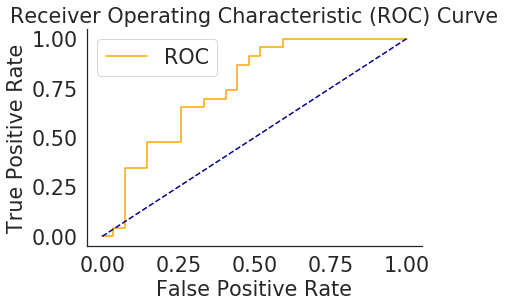

In [21]:
plot_roc_curve(fpr, tpr)

### 7. compute AUC score
if 0.5, classifier is picking randomly.

0.5 --> 1 classifier performance is improving

In [22]:
auc = roc_auc_score(testy, probs)
print('AUC: %.2f' % auc)

AUC: 0.75
